In [103]:
!pip install --quiet transformers datasets sentencepiece evaluate rouge_score

  Preparing metadata (setup.py) ... done


# Importing Libraries

In [2]:
from datasets import load_dataset_builder, load_dataset, Dataset
import transformers
from transformers import GPT2Config, GPT2Model, GPT2Tokenizer, GPT2LMHeadModel
import torch
from torch.utils.data import DataLoader
import gc

import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

import evaluate
import warnings

# Model

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token      # tokenizer does not have a padding token by default. ref: https://github.com/huggingface/transformers/issues/2630#issuecomment-1290809338
tokenizer.padding_side = "left"

# configuration = GPT2Config()
# model = GPT2Model(configuration)
# configuration = model.config

# model = GPT2Model.from_pretrained(model_name).to(device)
model = GPT2LMHeadModel.from_pretrained(model_name).to(device)

model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [4]:
model.config

GPT2Config {
  "_name_or_path": "gpt2",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "transformers_version": "4.28.1",
  "use_cache": true,
  "vocab_size": 50257
}

# Xsum Dataset

## Load Dataset

In [5]:
ds_builder = load_dataset_builder("xsum")
print(ds_builder.info.description)
print(ds_builder.info.features)


Extreme Summarization (XSum) Dataset.

There are three features:
  - document: Input news article.
  - summary: One sentence summary of the article.
  - id: BBC ID of the article.


{'document': Value(dtype='string', id=None), 'summary': Value(dtype='string', id=None), 'id': Value(dtype='string', id=None)}


In [6]:
dataset = load_dataset("xsum")
dataset

  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 204045
    })
    validation: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 11332
    })
    test: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 11334
    })
})

In [ ]:
print(dataset.column_names)

{'train': ['document', 'summary', 'id'], 'validation': ['document', 'summary', 'id'], 'test': ['document', 'summary', 'id']}


In [ ]:
for k, v in dataset["train"][0].items():
    print(k,'=',v)
    print()

document = The full cost of damage in Newton Stewart, one of the areas worst affected, is still being assessed.
Repair work is ongoing in Hawick and many roads in Peeblesshire remain badly affected by standing water.
Trains on the west coast mainline face disruption due to damage at the Lamington Viaduct.
Many businesses and householders were affected by flooding in Newton Stewart after the River Cree overflowed into the town.
First Minister Nicola Sturgeon visited the area to inspect the damage.
The waters breached a retaining wall, flooding many commercial properties on Victoria Street - the main shopping thoroughfare.
Jeanette Tate, who owns the Cinnamon Cafe which was badly affected, said she could not fault the multi-agency response once the flood hit.
However, she said more preventative work could have been carried out to ensure the retaining wall did not fail.
"It is difficult but I do think there is so much publicity for Dumfries and the Nith - and I totally appreciate that - b

## Data Preprocessing

In [7]:
## GPT2 requires adding "TL;DR" at the end of input text to generate summaries

def add_tldr(example):
  example["document"] = example["document"] + "\nTL;DR"
  return example

xsum_dataset = dataset["test"].map(add_tldr)

In [ ]:
for k, v in xsum_dataset[2500].items():
  print(k, '=', v)
  print()

document = The 58-year-old plans to develop a giant aircraft that would put spaceships into orbit, rather than lifting them off from a launch pad.
Other moguls are in the private space race, too, after Nasa this year ended its 30-year space shuttle programme.
Virgin Galactic is working on a commercial space venture which aims to fly passengers into sub-orbit by 2013.
Aerospace pioneer Burt Rutan is a partner on Mr Allen's project, which is called Stratolaunch Systems.
The project is the latest to be led by Silicon Valley tycoons who think they spy a gap in demand opened by the retirement of the US government's space shuttle programme.
While Nasa put rockets into space from a launch pad, the Stratolaunch plan is to launch unmanned rockets from high-flying aircraft, and eventually undertake manned missions too.
The developers said their aircraft could ferry cargo for the commercial satellite industry and the International Space Station.
The giant plane would be powered by six 747 jumbo j

In [ ]:
input = tokenizer(xsum_dataset[2500]["document"], truncation=True, padding="longest", return_tensors="pt").to(device)

In [ ]:
for k, v in input.items():
  print(k, '=', v)
  print()

input_ids = tensor([[  464,  7618,    12,  1941,    12,   727,  3352,   284,  1205,   257,
          6175,  6215,   326,   561,  1234,  9029,  5748,   656, 13066,    11,
          2138,   621, 16842,   606,   572,   422,   257,  4219, 14841,    13,
           198,  6395, 32985,  5753,   389,   287,   262,  2839,  2272,  3234,
            11,  1165,    11,   706, 48673,   428,   614,  4444,   663,  1542,
            12,  1941,  2272, 20992, 11383,    13,   198, 34674, 23509,   318,
          1762,   319,   257,  5068,  2272, 13189,   543, 12031,   284,  6129,
         10405,   656,   850,    12, 42594,   416,  2211,    13,   198,    32,
           263, 24912, 29570,   347,  3325, 21214,   272,   318,   257,  5212,
           319,  1770,  9659,   338,  1628,    11,   543,   318,  1444, 29186,
           349, 11429, 11998,    13,   198,   464,  1628,   318,   262,  3452,
           284,   307,  2957,   416, 18210,  6916,  1259,  1073,   684,   508,
           892,   484, 13997,   257,  76

In [ ]:
# output = model.generate(**input, output_hidden_states=True, output_scores=True, return_dict_in_generate=True)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Input length of input_ids is 529, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


In [ ]:
output_ = model(**input, output_hidden_states=True)

In [ ]:
# print(output)

GreedySearchDecoderOnlyOutput(sequences=tensor([[  464,  7618,    12,  1941,    12,   727,  3352,   284,  1205,   257,
          6175,  6215,   326,   561,  1234,  9029,  5748,   656, 13066,    11,
          2138,   621, 16842,   606,   572,   422,   257,  4219, 14841,    13,
           198,  6395, 32985,  5753,   389,   287,   262,  2839,  2272,  3234,
            11,  1165,    11,   706, 48673,   428,   614,  4444,   663,  1542,
            12,  1941,  2272, 20992, 11383,    13,   198, 34674, 23509,   318,
          1762,   319,   257,  5068,  2272, 13189,   543, 12031,   284,  6129,
         10405,   656,   850,    12, 42594,   416,  2211,    13,   198,    32,
           263, 24912, 29570,   347,  3325, 21214,   272,   318,   257,  5212,
           319,  1770,  9659,   338,  1628,    11,   543,   318,  1444, 29186,
           349, 11429, 11998,    13,   198,   464,  1628,   318,   262,  3452,
           284,   307,  2957,   416, 18210,  6916,  1259,  1073,   684,   508,
           8

In [ ]:
print(output_)

CausalLMOutputWithCrossAttentions(loss=None, logits=tensor([[[ -36.2875,  -35.0114,  -38.0794,  ...,  -40.5164,  -41.3760,
           -34.9194],
         [ -46.8871,  -42.6035,  -47.5720,  ...,  -49.9105,  -52.0880,
           -46.5096],
         [ -41.4456,  -39.3806,  -41.3288,  ...,  -50.1155,  -49.3654,
           -41.7125],
         ...,
         [ -90.6513,  -90.6124,  -92.8737,  ..., -100.2512,  -94.8702,
           -87.2627],
         [ -90.4059,  -88.5835,  -89.7060,  ...,  -99.8591,  -94.7330,
           -88.6694],
         [ -71.4707,  -71.9659,  -72.8554,  ...,  -80.5367,  -78.6035,
           -65.9654]]], device='cuda:0', grad_fn=<UnsafeViewBackward0>), past_key_values=((tensor([[[[-0.9420,  1.9023,  0.8722,  ..., -1.2703, -0.4792,  1.2469],
          [-2.4264,  2.3726,  1.8181,  ..., -1.2160, -1.8774,  1.2674],
          [-1.9781,  3.0301,  2.0410,  ..., -0.5624, -1.9179,  1.7366],
          ...,
          [ 1.0665,  0.9803, -1.6351,  ...,  0.5204,  1.4847, -2.4060],
    

In [ ]:
# print(output.hidden_states[-1][-1])

tensor([[[-0.0470, -0.0333, -0.1626,  ..., -0.1337, -0.0571, -0.1059],
         [ 0.4783,  0.5455,  0.5523,  ..., -0.2615, -0.1260, -0.1804],
         [ 0.3532, -0.1254,  0.0650,  ..., -0.4620,  0.0722,  0.2935],
         ...,
         [ 0.5783,  0.0455,  0.5869,  ..., -0.0471, -0.0632,  0.1805],
         [ 0.5266,  0.9584, -0.1785,  ...,  0.0439, -0.5484,  0.7059],
         [ 0.6282, -0.1396, -0.7631,  ...,  0.0508, -0.4036,  0.5429]]])


In [ ]:
print(output_.hidden_states[-1])

tensor([[[-0.0470, -0.0333, -0.1626,  ..., -0.1337, -0.0571, -0.1059],
         [ 0.4783,  0.5455,  0.5523,  ..., -0.2615, -0.1260, -0.1804],
         [ 0.3532, -0.1254,  0.0650,  ..., -0.4620,  0.0722,  0.2935],
         ...,
         [ 0.5783,  0.0455,  0.5869,  ..., -0.0471, -0.0632,  0.1805],
         [ 0.5266,  0.9584, -0.1785,  ...,  0.0439, -0.5484,  0.7059],
         [ 0.6282, -0.1396, -0.7631,  ...,  0.0508, -0.4036,  0.5429]]],
       device='cuda:0', grad_fn=<ViewBackward0>)


In [ ]:
print(len(output_.hidden_states))

13


In [ ]:
print(output_.hidden_states[-1].size())

torch.Size([1, 529, 768])


In [ ]:
# There are 529 tokens (words, etc.) in the document. Take average over the tokens
print(output_.hidden_states[-1].mean(axis=1).size())

torch.Size([1, 768])


## Hidden State Computation

In [8]:
batch_size = 8

all_last_hidden_states = []         # Decoder only

In [ ]:
with torch.no_grad():
  for i in range(0, len(xsum_dataset), batch_size):
    batch = tokenizer(xsum_dataset[i:min(i+batch_size,len(xsum_dataset))]["document"], truncation=True, padding="longest", return_tensors="pt").to(device)
    outputs = model(**batch, output_hidden_states=True)
    hidden_states = outputs.hidden_states[-1].mean(axis=1).to("cpu")
    for j in range(hidden_states.shape[0]):
      all_last_hidden_states.append(hidden_states[j,:].reshape(1,-1))
    del outputs
    del batch
    gc.collect()
    torch.cuda.empty_cache()

In [ ]:
all_last_hidden_states = torch.cat(all_last_hidden_states, dim=0)
torch.save({
  "hidden": all_last_hidden_states
}, "result_xsum_gpt2.pt")

## Test Summary Computation

In [8]:
batch_size = 8

summaries = []

In [ ]:
# with torch.no_grad():
#   for i in range(8000, 10000, batch_size):
#     print(i, end=' ')
#     batch = tokenizer(xsum_dataset[i:min(i+batch_size,len(xsum_dataset))]["document"], truncation=True, padding="longest", return_tensors="pt").to(device)
#     outputs = model.generate(**batch, max_new_tokens = 64)
#     summaries += (tokenizer.batch_decode(outputs, skip_special_tokens=True))
#     del outputs
#     del batch
#     gc.collect()
#     torch.cuda.empty_cache()

In [9]:
small_doc_indices = []
for i in range(10000):
  if(len(xsum_dataset[i]["document"][:-6]) > 0 and len(xsum_dataset[i]["document"][:-6]) < 1000):
    small_doc_indices.append(i)

small_doc_indices = np.random.permutation(small_doc_indices)[:500]

xsum_dataset_taken = xsum_dataset[small_doc_indices]
xsum_dataset_taken = Dataset.from_dict(xsum_dataset_taken)

with torch.no_grad():
  for i in range(0, len(xsum_dataset_taken), batch_size):
    print(i, end=' ')
    batch = tokenizer(xsum_dataset_taken[i:min(i+batch_size,len(xsum_dataset_taken))]["document"], truncation=True, padding="longest", return_tensors="pt").to(device)
    outputs = model.generate(**batch, max_new_tokens = 64)
    summaries += (tokenizer.batch_decode(outputs, skip_special_tokens=True))       # Returns document with summary after "TL;DR: "
    del outputs
    del batch
    gc.collect()
    torch.cuda.empty_cache()

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


8 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


16 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


24 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


32 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


40 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


48 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


56 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


64 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


72 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


80 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


88 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


96 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


104 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


112 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


120 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


128 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


136 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


144 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


152 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


160 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


168 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


176 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


184 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


192 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


200 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


208 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


216 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


224 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


232 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


240 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


248 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


256 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


264 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


272 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


280 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


288 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


296 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


304 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


312 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


320 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


328 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


336 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


344 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


352 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


360 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


368 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


376 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


384 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


392 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


400 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


408 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


416 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


424 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


432 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


440 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


448 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


456 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


464 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


472 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


480 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


488 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


496 

In [11]:
torch.save({
  "predictions": summaries,
  "indices": small_doc_indices,
  "dataset_summaries": xsum_dataset[small_doc_indices]["summary"]
}, "xsum_test_summaries_gpt2.pt")

# C4 Dataset

## Load Dataset

In [ ]:
ds_builder = load_dataset_builder("stas/c4-en-10k")
print(ds_builder.info.description)
print(ds_builder.info.features)

This is a small subset representing the first 10K records of the original C4 dataset, "en" subset - created for testing. The records were extracted after having been shuffled.

The full 1TB+ dataset is at https://huggingface.co/datasets/c4.

{'text': Value(dtype='string', id=None)}


In [ ]:
dataset = load_dataset("stas/c4-en-10k")
dataset

  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 10000
    })
})

In [ ]:
print(dataset.column_names)

{'train': ['text']}


In [ ]:
for k, v in dataset["train"][0].items():
  print(k, '=', v)
  print()

text = Beginners BBQ Class Taking Place in Missoula!
Do you want to get better at making delicious BBQ? You will have the opportunity, put this on your calendar now. Thursday, September 22nd join World Class BBQ Champion, Tony Balay from Lonestar Smoke Rangers. He will be teaching a beginner level class for everyone who wants to get better with their culinary skills.
He will teach you everything you need to know to compete in a KCBS BBQ competition, including techniques, recipes, timelines, meat selection and trimming, plus smoker and fire information.
The cost to be in the class is $35 per person, and for spectators it is free. Included in the cost will be either a t-shirt or apron and you will be tasting samples of each meat that is prepared.



## Data Preprocessing

In [ ]:
def add_tldr1(example):
  example["text"] = example["text"] + " TL;DR"
  return example

c4_dataset = dataset["train"].map(add_tldr1)

In [ ]:
for k, v in c4_dataset[0].items():
  print(k, '=', v)
  print()

text = Beginners BBQ Class Taking Place in Missoula!
Do you want to get better at making delicious BBQ? You will have the opportunity, put this on your calendar now. Thursday, September 22nd join World Class BBQ Champion, Tony Balay from Lonestar Smoke Rangers. He will be teaching a beginner level class for everyone who wants to get better with their culinary skills.
He will teach you everything you need to know to compete in a KCBS BBQ competition, including techniques, recipes, timelines, meat selection and trimming, plus smoker and fire information.
The cost to be in the class is $35 per person, and for spectators it is free. Included in the cost will be either a t-shirt or apron and you will be tasting samples of each meat that is prepared. TL;DR



## Hidden State Computation

In [ ]:
batch_size = 8

all_last_hidden_states = []

In [ ]:
with torch.no_grad():
  for i in range(0, len(c4_dataset), batch_size):
    batch = tokenizer(c4_dataset[i:min(i+batch_size,len(c4_dataset))]["text"], truncation=True, padding="longest", return_tensors="pt").to(device)
    outputs = model(**batch, output_hidden_states=True)
    hidden_states = outputs.hidden_states[-1].mean(axis=1).to("cpu")
    for j in range(hidden_states.shape[0]):
      all_last_hidden_states.append(hidden_states[j,:].reshape(1,-1))
    del outputs
    del batch
    gc.collect()
    torch.cuda.empty_cache()

In [ ]:
all_last_hidden_states = torch.cat(all_last_hidden_states, dim=0)
torch.save({
    "hidden": all_last_hidden_states
}, "result_c4_gpt2.pt")

# Cnn_dailymail Dataset

## Load Dataset

In [12]:
ds_builder = load_dataset_builder("cnn_dailymail", "3.0.0")
print(ds_builder.info.description)
print(ds_builder.info.features)

CNN/DailyMail non-anonymized summarization dataset.

There are two features:
  - article: text of news article, used as the document to be summarized
  - highlights: joined text of highlights with <s> and </s> around each
    highlight, which is the target summary

{'article': Value(dtype='string', id=None), 'highlights': Value(dtype='string', id=None), 'id': Value(dtype='string', id=None)}


In [13]:
dataset = load_dataset("cnn_dailymail", "3.0.0", split="test")
dataset

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

Dataset cnn_dailymail downloaded and prepared to /root/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de. Subsequent calls will reuse this data.


Dataset({
    features: ['article', 'highlights', 'id'],
    num_rows: 11490
})

In [ ]:
print(dataset.column_names)

['article', 'highlights', 'id']


In [ ]:
for k, v in dataset[0].items():
  print(k, '=', v)
  print()

article = (CNN)The Palestinian Authority officially became the 123rd member of the International Criminal Court on Wednesday, a step that gives the court jurisdiction over alleged crimes in Palestinian territories. The formal accession was marked with a ceremony at The Hague, in the Netherlands, where the court is based. The Palestinians signed the ICC's founding Rome Statute in January, when they also accepted its jurisdiction over alleged crimes committed "in the occupied Palestinian territory, including East Jerusalem, since June 13, 2014." Later that month, the ICC opened a preliminary examination into the situation in Palestinian territories, paving the way for possible war crimes investigations against Israelis. As members of the court, Palestinians may be subject to counter-charges as well. Israel and the United States, neither of which is an ICC member, opposed the Palestinians' efforts to join the body. But Palestinian Foreign Minister Riad al-Malki, speaking at Wednesday's ce

## Data Preprocessing

In [14]:
def add_tldr2(example):
  example["article"] = example["article"] + "\nTL;DR"
  return example

cnn_dailymail_dataset = dataset.map(add_tldr2)

Map:   0%|          | 0/11490 [00:00<?, ? examples/s]

In [ ]:
type(cnn_dailymail_dataset)

datasets.arrow_dataset.Dataset

In [ ]:
num_test_samples = 2000

indices_taken = torch.randperm(len(cnn_dailymail_dataset))[:num_test_samples]
cnn_dailymail_dataset = cnn_dailymail_dataset[indices_taken]
print(len(cnn_dailymail_dataset["article"]))

2000


In [ ]:
type(cnn_dailymail_dataset)

dict

In [ ]:
print(cnn_dailymail_dataset.keys())

dict_keys(['article', 'highlights', 'id'])


In [ ]:
type(cnn_dailymail_dataset["article"])

list

In [ ]:
print(cnn_dailymail_dataset["article"][1000])

Exeter swept aside Newcastle 48-13 to set up a semi-final showdown with Gloucester in the inaugural European Challenge Cup. The Chiefs outscored their opponents six tries to one at Sandy Park, with a David Ewers score and a penalty try helping the home side into a 17-6 half-time lead. Exeter then added further tries through Thomas Waldrom, Byron McGuigan, Sam Hill and Dean Mumm after the break, with outclassed Newcastle only able to respond with a 68th-minute effort from Chris Harris and eight points from the boot of Tom Catterick. Carl Rimmer of Exeter Chiefs is tackled by Newcastle Falcons' Dom Barrow during match at Sandy Park . Exeter's Thomas Waldrom stretches over for a try during the European Rugby Challenge Cup match . The victory means Exeter will take on Gloucester at Kingsholm in two weeks' time for a place in the final against either Newport Gwent Dragons or the winner of Sunday's London Irish-Edinburgh encounter. The hosts made a number of changes from the side that lost 2

In [ ]:
print(cnn_dailymail_dataset["highlights"][1000])

Exeter and Gloucester will go head-to-head for place in inaugural final .
Winner will face either Newport Gwent Dragons, London Irish or Edinburgh .
David Ewers helped his side into a 17-6 half-time lead .


In [ ]:
cnn_dailymail_dataset = Dataset.from_dict(cnn_dailymail_dataset)

In [ ]:
type(cnn_dailymail_dataset)

datasets.arrow_dataset.Dataset

In [ ]:
for k, v in cnn_dailymail_dataset[0].items():
  print(k, '=', v)
  print()

article = Nigel Farage has admitted that he has a 'preference' for Australian immigrants over Eastern Europeans and Somalians. The Ukip leader said he had to 'confess' that he was happier accepting migrants from Commonwealth countries such as Australian and India because they could speak English and understood Britain's legal system. The controversial remarks come after Mr Farage demanded that refugees fleeing to Europe across the Mediterranean are sent back. Scroll down for video . Nigel Farage, speaking to BBC Newsnight,  admitted that he has a 'preference' for Australian immigrants over Eastern Europeans and Somalians . Mr Farage, who has also admitted today that he went 'a bit wonky' and made mistakes at the start of Ukip's election campaign, was asked on BBC Newsnight whether he was anti all immigration or preferred some foreigners to others. The BBC presenter Evan Davis asked: 'Let's suppose one from Mogadishu with the same skills, the same ability to speak English, but not as a 

## Hidden State Computation

In [ ]:
batch_size = 8

all_last_hidden_states = []

In [ ]:
with torch.no_grad():
  for i in range(0, len(cnn_dailymail_dataset), batch_size):
    print(i, end=' ')
    batch = tokenizer(cnn_dailymail_dataset[i:min(i+batch_size,len(cnn_dailymail_dataset))]["article"], truncation=True, padding="longest", return_tensors="pt").to(device)
    outputs = model(**batch, output_hidden_states=True)
    hidden_states = outputs.hidden_states[-1].mean(axis=1).to("cpu")
    for j in range(hidden_states.shape[0]):
      all_last_hidden_states.append(hidden_states[j,:].reshape(1,-1))
    del outputs
    del batch
    gc.collect()
    torch.cuda.empty_cache()

0 8 16 24 32 40 48 56 64 72 80 88 96 104 112 120 128 136 144 152 160 168 176 184 192 200 208 216 224 232 240 248 256 264 272 280 288 296 304 312 320 328 336 344 352 360 368 376 384 392 400 408 416 424 432 440 448 456 464 472 480 488 496 504 512 520 528 536 544 552 560 568 576 584 592 600 608 616 624 632 640 648 656 664 672 680 688 696 704 712 720 728 736 744 752 760 768 776 784 792 800 808 816 824 832 840 848 856 864 872 880 888 896 904 912 920 928 936 944 952 960 968 976 984 992 1000 1008 1016 1024 1032 1040 1048 1056 1064 1072 1080 1088 1096 1104 1112 1120 1128 1136 1144 1152 1160 1168 1176 1184 1192 1200 1208 1216 1224 1232 1240 1248 1256 1264 1272 1280 1288 1296 1304 1312 1320 1328 1336 1344 1352 1360 1368 1376 1384 1392 1400 1408 1416 1424 1432 1440 1448 1456 1464 1472 1480 1488 1496 1504 1512 1520 1528 1536 1544 1552 1560 1568 1576 1584 1592 1600 1608 1616 1624 1632 1640 1648 1656 1664 1672 1680 1688 1696 1704 1712 1720 1728 1736 1744 1752 1760 1768 1776 1784 1792 1800 1808 1816 

In [ ]:
all_last_hidden_states = torch.cat(all_last_hidden_states, dim=0)
torch.save({
    "indices_taken": indices_taken,         # as only some are taken
    "hidden": all_last_hidden_states
}, "result_cnn_dailymail_gpt2.pt")

## Summary Computation

In [15]:
cnn_dailymail_dataset = dataset.map(add_tldr2)

In [16]:
batch_size = 8

summaries = []

In [17]:
indices_taken = torch.load("result_cnn_dailymail_gpt2.pt")["indices_taken"]

In [18]:
cnn_dailymail_dataset_taken = cnn_dailymail_dataset[indices_taken]              # returns dict
cnn_dailymail_dataset_taken = Dataset.from_dict(cnn_dailymail_dataset_taken)    # converts to datasets.arrow_dataset.Dataset

In [ ]:
# with torch.no_grad():
#   for i in range(0, len(cnn_dailymail_dataset_taken), batch_size):
#     print(i, end=' ')
#     batch = tokenizer(cnn_dailymail_dataset_taken[i:min(i+batch_size,len(cnn_dailymail_dataset_taken))]["article"], truncation=True, padding="longest", return_tensors="pt").to(device)
#     outputs = model.generate(**batch, max_length = 64)                      # max number of tokens generated is max_new_tokens
#     summaries += (tokenizer.batch_decode(outputs, skip_special_tokens=True))
#     del outputs
#     del batch
#     gc.collect()
#     torch.cuda.empty_cache()

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


0 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


8 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


16 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


24 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


32 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


40 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


48 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


56 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


64 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


72 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


80 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


88 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


96 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


104 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


112 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


120 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 914, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


128 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


136 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


144 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


152 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


160 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


168 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 936, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


176 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


184 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


192 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1015, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


200 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


208 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


216 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


224 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


232 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


240 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


248 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


256 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


264 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


272 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


280 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


288 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


296 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


304 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


312 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


320 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


328 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


336 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


344 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


352 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


360 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


368 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


376 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


384 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


392 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


400 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


408 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


416 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


424 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


432 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


440 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


448 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


456 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


464 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


472 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 970, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


480 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


488 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


496 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


504 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


512 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


520 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


528 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


536 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


544 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


552 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


560 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 880, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


568 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


576 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 979, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


584 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


592 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


600 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


608 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


616 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


624 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 988, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


632 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


640 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


648 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


656 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


664 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


672 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


680 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1016, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


688 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


696 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


704 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


712 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


720 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


728 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


736 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


744 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


752 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


760 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


768 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


776 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


784 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


792 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


800 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


808 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


816 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


824 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


832 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


840 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


848 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


856 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


864 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


872 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


880 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


888 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


896 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


904 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


912 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 965, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


920 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


928 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


936 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


944 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


952 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


960 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


968 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


976 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


984 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


992 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1000 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1008 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1016 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1024 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1032 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1040 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1048 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1056 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1064 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1072 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1080 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1088 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1096 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1104 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1112 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1120 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 893, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1128 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1136 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1144 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1152 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1160 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1168 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1176 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1184 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1192 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1200 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1208 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1216 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1224 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1232 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1240 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1248 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1256 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 830, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1264 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1272 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1280 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1288 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1296 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1304 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1312 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1320 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1328 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1336 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1344 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1352 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1360 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1368 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 887, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1376 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1384 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1392 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1400 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1408 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1416 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1424 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1432 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1440 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1448 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 944, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1456 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1464 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1472 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1480 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1488 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1496 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1504 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1512 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1520 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1528 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1536 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1544 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1552 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1560 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1568 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1576 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1584 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1592 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1600 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 880, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1608 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1616 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1624 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1632 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1640 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1648 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1656 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1664 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1672 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1680 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1688 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1696 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1704 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1712 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1720 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1728 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1736 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 991, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1744 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1752 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1760 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1768 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1776 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1784 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1792 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1800 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1808 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1816 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1824 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1832 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1840 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1848 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 727, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1856 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1864 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1872 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1880 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1888 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1896 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1904 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1912 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1920 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1928 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1936 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1944 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1952 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1960 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1968 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1976 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1984 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 64. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1992 

In [29]:
small_art_indices = []
for i in range(2000):
  if(len(cnn_dailymail_dataset_taken[i]["article"][:-6]) > 0 and len(cnn_dailymail_dataset_taken[i]["article"][:-6]) < 2500):
    small_art_indices.append(i)

small_art_indices = np.random.permutation(small_art_indices)[:500]

dataset_taken = cnn_dailymail_dataset_taken[small_art_indices]
cnn_dailymail_dataset_taken = Dataset.from_dict(dataset_taken)

with torch.no_grad():
  for i in range(0, len(cnn_dailymail_dataset_taken), batch_size):
    print(i, end=' ')
    batch = tokenizer(cnn_dailymail_dataset_taken[i:min(i+batch_size,len(cnn_dailymail_dataset_taken))]["article"], truncation=True, padding="longest", return_tensors="pt").to(device)
    outputs = model.generate(**batch, max_new_tokens = 64)                      # max number of tokens generated is max_new_tokens
    summaries += (tokenizer.batch_decode(outputs, skip_special_tokens=True))
    del outputs
    del batch
    gc.collect()
    torch.cuda.empty_cache()

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


8 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


16 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


24 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


32 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


40 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


48 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


56 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


64 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


72 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


80 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


88 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


96 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


104 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


112 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


120 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


128 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


136 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


144 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


152 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


160 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


168 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


176 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


184 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


192 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


200 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


208 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


216 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


224 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


232 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


240 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


248 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


256 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


264 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


272 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


280 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


288 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


296 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


304 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


312 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


320 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


328 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


336 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


344 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


352 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


360 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


368 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


376 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


384 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


392 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


400 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


408 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


416 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


424 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


432 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


440 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


448 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


456 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


464 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


472 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


480 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


488 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


496 

In [34]:
cnn_dailymail_dataset_taken = cnn_dailymail_dataset[indices_taken]              # run again to save the dataset summaries in next cell
cnn_dailymail_dataset_taken = Dataset.from_dict(cnn_dailymail_dataset_taken)    

In [36]:
torch.save({
  "predictions": summaries,
  "indices": small_art_indices,
  "dataset_summaries": cnn_dailymail_dataset_taken[small_art_indices]["highlights"]
}, "cnn_dailymail_test_summaries_gpt2.pt")

# Fit In-domain and Background Gaussians

In [ ]:
dataset_names = {
  "indomain": "xsum",
  "background": "c4",
  "ood": "cnn_dailymail"
}

means = {
  "decoder": {}
}
covs = {
  "decoder": {}
}
test_states = {
  "decoder": {}
}

In [ ]:
for k, v in dataset_names.items():
  saved_embed = torch.load(f"result_{v}_gpt2.pt")
  all_last_hidden_states = saved_embed["hidden"]

  # gaussians fit using 8000 samples
  # test: 2000 of xsum, and 2000 of cnn_dailymail

  # num_total = all_last_hidden_states.shape[0]
  num_total = 10000
  train_fraction = 0.8
  num_train = int(train_fraction*num_total)

  if k != "ood":
    print(k, v, num_total, num_train)
    
    train_decoder = all_last_hidden_states[:num_train]
    if k == "indomain":
      test_states["decoder"][k] = all_last_hidden_states[num_train:num_total]

    means["decoder"][k] = torch.mean(train_decoder, 0)
    covs["decoder"][k] = torch.cov(train_decoder.T)
  else:
    print(k, v, all_last_hidden_states.shape[0])
    assert all_last_hidden_states.shape[0] == num_total-num_train

    test_states["decoder"][k] = all_last_hidden_states

indomain xsum 10000 8000
background c4 10000 8000
ood cnn_dailymail 2000


In [ ]:
torch.save({
  "means": means,
  "covs": covs,
  "test_states": test_states
}, "means_covs_tests.pt")

# RMD and AUROC

In [ ]:
def mahalanobis_distance(vectors, mean, cov, epsilon=1e-20):
  """
  vectors: (num_samples, dim)
  mean: dim
  cov: (dim, dim)
  """

  assert vectors.shape[1] == mean.shape[0]
  assert cov.shape[0] == cov.shape[1] and cov.shape[0] == mean.shape[0]

  # add eps*I (prevents singular matrix)
  cov_eps = cov + torch.eye(cov.shape[0])*epsilon
  cov_eps_inv = torch.inverse(cov_eps)

  num_samples = vectors.shape[0]
  out = torch.zeros(num_samples)
  for i in range(num_samples):
    out[i] = ((vectors[i]-mean) @ cov_eps_inv @ (vectors[i]-mean).reshape(-1,1)).item()
  return out

In [ ]:
means_covs_tests = torch.load("means_covs_tests.pt")
means = means_covs_tests["means"]
covs = means_covs_tests["covs"]
test_states = means_covs_tests["test_states"]

In [ ]:
maha_dists = {
  "decoder": {
    "indomain": {},
    "ood": {}
  }
}

for part in ["decoder"]:
  for test in ["indomain", "ood"]:
    for fit_gaussian in ["indomain", "background"]:
      # compute MD of test samples with fitted Gaussians
      maha_dists[part][test][fit_gaussian] = mahalanobis_distance(
                                                  test_states[part][test],
                                                  means[part][fit_gaussian],
                                                  covs[part][fit_gaussian]
                                              )
torch.save(maha_dists, "maha_dists.pt")

In [ ]:
def get_auroc(preds, labels, display=False, title=None):
  fpr, tpr, thresholds = metrics.roc_curve(labels, preds)
  roc_auc = metrics.auc(fpr, tpr)
  if display:
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    display.plot()
    if title is not None:
      plt.title(title)
      plt.savefig(f"{title}.png", bbox_inches="tight")
    plt.show()
  return roc_auc

tensor(-2314.7881) tensor(5938.6592) tensor(-450.0595) tensor(12351.2178)
preds.min()=tensor(-2314.7881), preds.max()=tensor(12351.2178)


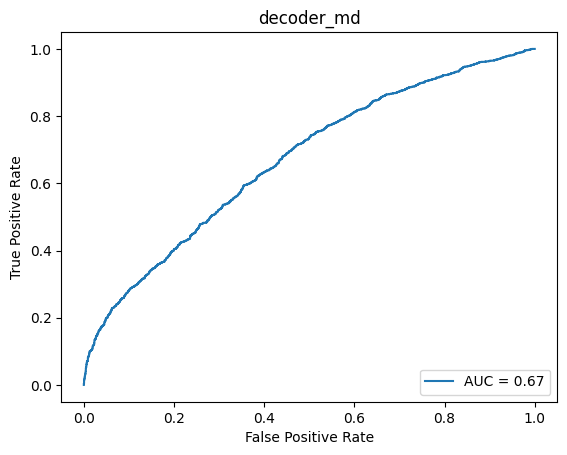

tensor(-5342.4731) tensor(2962.0735) tensor(-2931.1375) tensor(8339.1777)
preds.min()=tensor(-5342.4731), preds.max()=tensor(8339.1777)


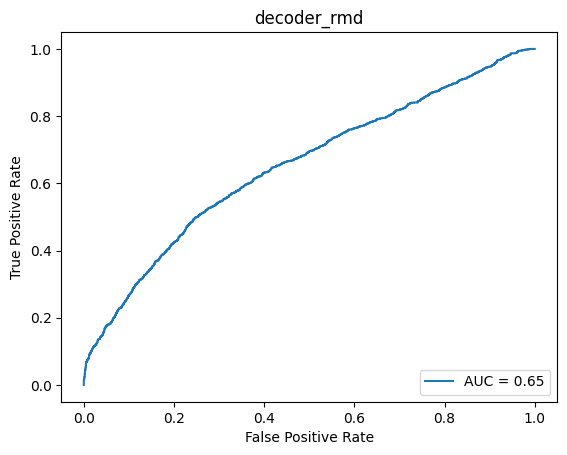

{'decoder': {'md': 0.6692765, 'rmd': 0.652352}}


In [ ]:
maha_dists = torch.load("maha_dists.pt")

aurocs = {
  "decoder": {}
}

scores = {
  "indomain": {
    "decoder": {}
  },
  "ood": {
    "decoder": {}
  }
}

for part in ["decoder"]:
  for method in ["md", "rmd"]:
    # scores computed as specified in section 2.2
    if method == "md":
      scores_indomain = maha_dists[part]["indomain"]["indomain"]
      scores_ood = maha_dists[part]["ood"]["indomain"]
    elif method == "rmd":
      scores_indomain = maha_dists[part]["indomain"]["indomain"] - maha_dists[part]["indomain"]["background"]
      scores_ood = maha_dists[part]["ood"]["indomain"] - maha_dists[part]["ood"]["background"]
    print(scores_indomain.min(), scores_indomain.max(), scores_ood.min(), scores_ood.max())     # use scaling? sigmoid?
                                                                                                # sigmoid worsens auroc

    scores["indomain"][part][method] = scores_indomain
    scores["ood"][part][method] = scores_ood

    # use 0,1 or -1,1? (doesn't appear to change results much currently)
    labels_indomain = torch.zeros_like(scores_indomain)
    labels_ood = torch.ones_like(scores_ood)
    
    preds = torch.cat((scores_indomain, scores_ood))
    # preds = torch.sigmoid(preds)
    print(f"{preds.min()=}, {preds.max()=}")
    labels = torch.cat((labels_indomain, labels_ood))
    aurocs[part][method] = get_auroc(preds.cpu().numpy(), labels.cpu().numpy(), display=True, title=f"{part}_{method}")

print(aurocs)

In [ ]:
torch.save({
  "scores": scores,
  "aurocs": aurocs
}, "scores_aurocs.pt")

# Perplexity

In [37]:
model.config.n_positions

1024

In [38]:
perplexity = evaluate.load("perplexity", module_type="metric")

In [39]:
predicted_summaries = torch.load("xsum_test_summaries_gpt2.pt")["predictions"] + torch.load("cnn_dailymail_test_summaries_gpt2.pt")["predictions"]
assert len(predicted_summaries) == 1000

In [62]:
print(predicted_summaries[500])         # contains the document/article first and then the summary after "TL;DR: "

2242

In [49]:
print(predicted_summaries[0][len(xsum_dataset_taken[0]["document"])+2:])        # separates the summary from rest of the text

A car was involved in a collision with a car on the A9 north of Berriedale.
The driver of the car was taken to hospital with minor injuries.
The driver of the car was taken to hospital with minor injuries.
The driver of the car was taken to hospital with minor injuries.



In [ ]:
print(xsum_dataset[8000]["document"][:-6])

A review of research for the Reading Agency says reading for pleasure does much more than boost educational outcomes among adults and children.
One recent study quoted - of 4,000 UK adults - says reading for pleasure can help them enjoy social occasions more.
It can also boost children's emotional understanding, the research adds.
In general, the study found reading was associated with enjoyment, relaxation and escapism.
The research involving a poll of 4,000 people that is cited by the report looked at how mental and physical health can be boosted by the enjoyment of reading.
It said those who read regularly for pleasure:
It also cited research carried out in Germany, with children aged seven to nine, that looked at possible links between literacy and emotional understanding.
The report focused on the impact of after-school literacy sessions in which children's books with emotional content were read and discussed by the group.
It found the scheme enhanced the children's emotional voca

In [53]:
# next cell requires the cnn_dailymail_dataset_taken with small_art_indices
small_art_indices = torch.load("cnn_dailymail_test_summaries_gpt2.pt")["indices"]
dataset_taken = cnn_dailymail_dataset_taken[small_art_indices]
cnn_dailymail_dataset_taken = Dataset.from_dict(dataset_taken)

In [83]:
generated_summaries = []

for i in range(len(predicted_summaries)//2):
  j = predicted_summaries[i].find("TL;DR")
  generated_summaries.append(predicted_summaries[i][j+7:])

for i in range(len(predicted_summaries)//2, len(predicted_summaries)):
  j = predicted_summaries[i].find("TL;DR")
  generated_summaries.append(predicted_summaries[i][j+7:])

In [89]:
print(generated_summaries[340])

Police are searching for a 26-year-old man who has been arrested on suspicion of child abduction, following the girl's disappearance on Thursday.
The girl from Teesside was found earlier, after being reported missing at 22:00 BST.
The search for her involved 30 officers.
The search for


In [92]:
print(generated_summaries[680])

Valencia are willing to pay £13 million for the right-back, but AS reports that both Chelsea and City are willing to pay the £13 million buyout clause for highly-rated Valencia left-back Jose Luis Gaya. The 19-year-old Spaniard is Real Madrid's first choice to fill the


In [94]:
perplexity_results = perplexity.compute(predictions=generated_summaries, model_id="gpt2")

Using pad_token, but it is not set yet.


  0%|          | 0/63 [00:00<?, ?it/s]

In [95]:
torch.save(perplexity_results, "perplexity_results.pt")

# Combined Perplexity and RMD Scores

In [96]:
scores = torch.load("scores_aurocs.pt")["scores"]
perplexities = torch.load("perplexity_results.pt")["perplexities"]

In [97]:
# pr_sums = {}

# for part in ["decoder"]:
#   num_samples = 1000
  
#   indomain_indices = torch.load("xsum_test_summaries_gpt2.pt")["indices"]
#   ood_indices = torch.load("")
#   indomain_rmd_scores = 
#   # rmd_scores = [e.item() for e in torch.cat((scores["indomain"][part]["rmd"], scores["ood"][part]["rmd"]))]
#   assert len(rmd_scores) == num_samples

#   rmd_sorted = sorted(rmd_scores)
#   pr_rmd = [(rmd_sorted.index(e)*100.0)/num_samples for e in rmd_scores]

#   perp_sorted = sorted(perplexities)
#   pr_perp = [(perp_sorted.index(e)*100.0)/num_samples for e in perplexities]

#   pr_sum = [pr_rmd[i]+pr_perp[i] for i in range(num_samples)]
#   pr_sums[part] = pr_sum

#   assert len(pr_sums[part]) == len(perplexities)
#   print(np.min(pr_sums[part]), np.max(pr_sums[part]))

AssertionError: ignored

In [ ]:
# torch.save(pr_sums, "pr_sums.pt")

# ROUGE-1

In [98]:
# ind_summaries = torch.load("xsum_test_summaries_gpt2.pt")
# ood_summaries = torch.load("cnn_dailymail_test_summaries_gpt2.pt")

In [101]:
# t = 400
# print(f"{ind_summaries['predictions'][t]=}")
# print(f"{ind_summaries['dataset_summaries'][t]=}")
# print(f"{ood_summaries['predictions'][t]=}")
# print(f"{ood_summaries['dataset_summaries'][t]=}")

ind_summaries['predictions'][t]='Holders Glasgow City joined Hibs in the fourth round with a 3-1 success over Rangers Ladies.\nCeltic also safely made their progression into the last 16 with a 3-1 win at home to Forfar Farmington.\nElsewhere in the third round there were wins for Glasgow Girls, Stirling University, Hearts, Hutchison Vale and Jeanfield Swifts.\nHibs are targeting a cup double after landing the SWPL Cup earlier in the season with victory over champions Glasgow City.\nThe two sides meet next weekend on league business, with Hibs trailing leaders City by two points.\nTL;DR: Hibs win the league and Hibs lose the cup.\nHibs are now in the top four of the league table, with a win over Hearts and a draw against Stirling University.\nHibs are also in the top four of the league table, with a win over Hearts and a draw'
ind_summaries['dataset_summaries'][t]='League Cup winners Hibernian Ladies beat Renfrew Ladies 19-0 in the third round of the Scottish Cup.'
ood_summaries['predic

In [104]:
# rouge = evaluate.load("rouge")

In [105]:
# scores = torch.load("scores_aurocs.pt")["scores"]
# # pr_sums = torch.load("pr_sums.pt")

In [111]:
# scores["indomain"]["decoder"]["md"]

tensor([ 684.4258, 1220.0569,  424.5029,  ...,  669.4215,  359.6492,
          65.6516])

In [ ]:
# rouge_scores = {
#   "decoder": {
#     "md": {},
#     "rmd": {},
#     # "pr_sum": {}
#   }
# }

# num_samples = 1000

# for part in ["decoder"]:
#   # for method in ["md", "rmd", "pr_sum"]:
#   for method in ["md", "rmd", "pr_sum"]:
      
#     if method in ["md", "rmd"]:
#       all_scores = torch.cat((scores["indomain"][part][method], scores["ood"][part][method]))
#     # elif method == "pr_sum":
#     #   all_scores = torch.Tensor(pr_sums[part])
    
#     assert all_scores.shape == torch.Size([num_samples])

#     prediction_summaries = ind_summaries["predictions"] + ood_summaries["predictions"]
#     reference_summaries = ind_summaries["dataset_summaries"] + ood_summaries["dataset_summaries"]

#     # sorting by scores (higher score: more ood)
#     sorting_indices = torch.argsort(all_scores)
#     predictions_sorted = []
#     references_sorted = []

#     for i in sorting_indices:
#       print(all_scores[int(i)], end=' ')
#       predictions_sorted.append(prediction_summaries[int(i)])
#       references_sorted.append(reference_summaries[int(i)])

#     print(len(predictions_sorted))

#     alpha = 0.0
#     num_total = len(sorting_indices)
#     while alpha < 0.9:
#       num_removed = int(num_total*alpha)
#       rouge_scores[part][method][alpha] = {}
#       rouge_scores[part][method][alpha] = rouge.compute(
#           predictions = predictions_sorted[:num_total-num_removed],
#           references = references_sorted[:num_total-num_removed]
#       )["rouge1"]
#       print(part, method, alpha, num_removed, rouge_scores[part][method][alpha])
#       alpha += 0.1
#       alpha = round(alpha, 1)

In [ ]:
# torch.save(rouge_scores, "rouge_scores.pt")

In [ ]:
# rouge_scores = torch.load("rouge_scores.pt")

# for part in rouge_scores.keys():
#   for method in rouge_scores[part].keys():
#     alphas = list(rouge_scores[part][method].keys())
#     r_scores = list(rouge_scores[part][method].values())
#     print(alphas, r_scores)
#     plt.plot(alphas, r_scores, label=method)
#   plt.title(f"{part}")
#   plt.xlabel("Abstention Rate")
#   plt.ylabel("rouge1")
#   plt.legend()
#   fig = plt.gcf()
#   plt.show()
#   fig.savefig(f"rouge_{part}.png", bbox_inches="tight")
#   plt.clf()